In [23]:
import numpy as np
import tensorflow_probability as tfp 
import tensorflow as tf
import matplotlib.pyplot as plt


#See:
#https://www.youtube.com/watch?v=dxwVMeK988Y&list=PLISXH-iEM4JloWnKysIEPPysGVg4v3PaP&index=6&ab_channel=MachineLearning%26Simulation


Text(0.5, 1.0, 'Samples of X~N(mu_true, sigma_true), ie the dataset')

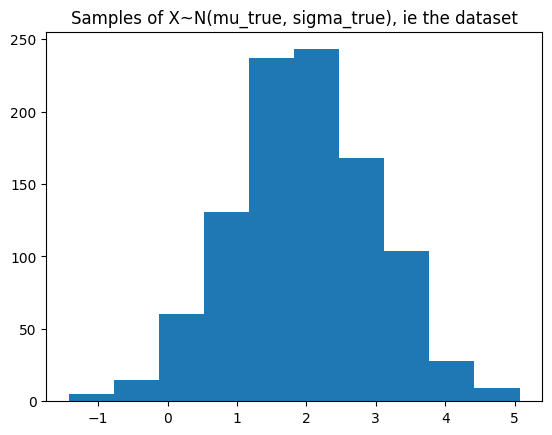

In [24]:
# Create a true latent random variable. These would most likely be unknowned to us in practice
mu_true  = 2
sigma_true = 1
N = 1000

X = tfp.distributions.Normal(loc=mu_true, scale=sigma_true)
# Sample some data
dataset = X.sample(N)


_ = plt.hist(dataset)
plt.title('Samples of X~N(mu_true, sigma_true), ie the dataset')

In [25]:
# Calculate True posterior of mu. These are only tractable in special cases. In this case we have that the prior and posterior are conjugate distributions
# Thus we get the following formulas

# Prior guess of mu ~ N(m0, s0)
m0 = 1.5
s0 = 0.3


mu_N = (sigma_true**2 * m0 + s0**2 * tf.reduce_sum(dataset)) / (sigma_true**2 + N*s0**2)
sigma_N = (s0 * sigma_true) / tf.sqrt(sigma_true**2 + N * s0**2)

print(mu_N, sigma_N)



tf.Tensor(1.963119, shape=(), dtype=float32) tf.Tensor(0.031448543, shape=(), dtype=float32)


For variational inference we need: Log-joint and Surrogate

In [26]:
# We

def generative_model(m0, s0, sigma, n_samples):
    # mu ~ N(m0, s0)
    # X ~  N(mu, sigma) , # ie sigma is known

    # Root: Wrapper for coroutine distributions which lack distribution parents.
    # JointDistributionCoroutine: This distribution enables both sampling and joint probability computation from a single model specification.
    mu = yield tfp.distributions.JointDistributionCoroutine.Root(tfp.distributions.Normal(loc=m0, scale=s0, name='mu'))
    # We yield a batch of n_samples
    X =  yield tfp.distributions.Normal(loc=mu * tf.ones(n_samples), scale=sigma, name='X')

# JointDistributionCoroutineAutoBatched :This class provides automatic vectorization and alternative semantics for 
#   tfd.JointDistributionCoroutine, which in many cases allows for simplifications in the model specification.
#   Takes a model as an argument

model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(lambda: generative_model(m0, s0, sigma_true, N))


Text(0.5, 1.0, 'samples of X~N(mu, sigma), given, mu = N(m0, s0)')

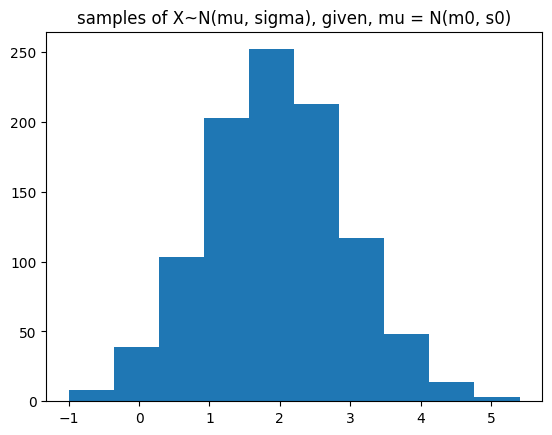

In [27]:
sample = model_joint.sample()
plt.hist(sample[1])

plt.title('samples of X~N(mu, sigma), given, mu = N(m0, s0)')

Text(0.5, 1.0, 'model_joint_logprob')

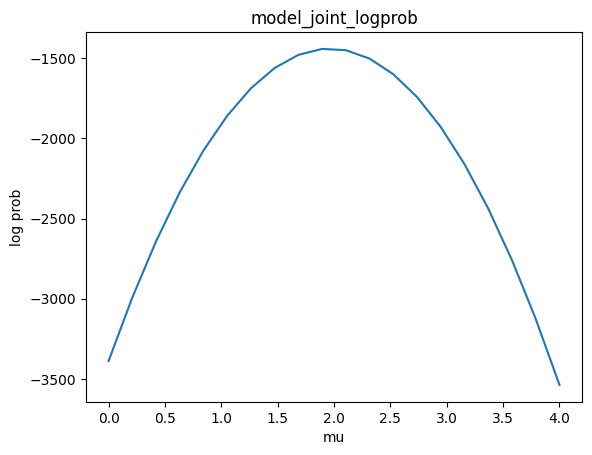

In [28]:

# How likely is it that a given mu represents the mu that underlies the data
model_joint_logprob = lambda mu: model_joint.log_prob(mu, dataset)

x = np.linspace(0,4,20)
y = [model_joint_logprob(i) for i in x]

plt.plot(x,y)
plt.xlabel('mu')
plt.ylabel('log prob')
plt.title('model_joint_logprob')


# Surrogate posterior

In [29]:
# Start by defining learnable parameters

mu_S = tf.Variable(m0, name='mu surrogate')
# Since we have the constraint that sigma_S has to be >= 0 we need to use Softplus.
sigma_S = tfp.util.TransformedVariable(s0, name='sigma surrogate', bijector=tfp.bijectors.Softplus()) 

model_surrogate_posterior = tfp.distributions.Normal(loc=mu_S, scale=sigma_S, name='surrogate_post')

model_surrogate_posterior

<tfp.distributions.Normal 'surrogate_post' batch_shape=[] event_shape=[] dtype=float32>

Text(0.5, 1.0, 'model_surrogate_posterior pre training')

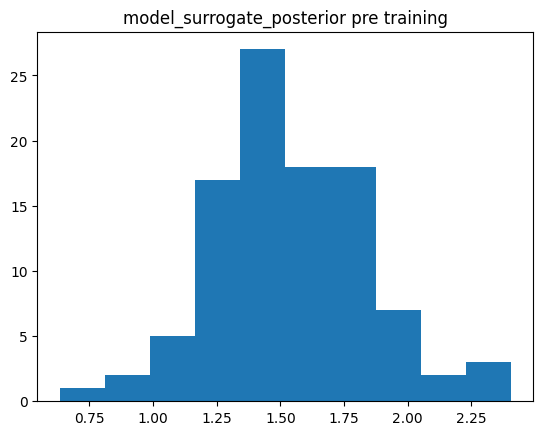

In [30]:
plt.hist(model_surrogate_posterior.sample(100))

plt.title('model_surrogate_posterior pre training')

In [31]:
model_surrogate_posterior.trainable_variables

(<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'sigma surrogate:0' shape=() dtype=float32, numpy=-1.0502257>)

In [32]:
# In above its shown as its untransformed version
sigma_S

<TransformedVariable: dtype=float32, shape=[], fn="softplus", numpy=0.29999995>

In [33]:
model_surrogate_posterior.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.2422569, 1.6339108, 1.8314246], dtype=float32)>

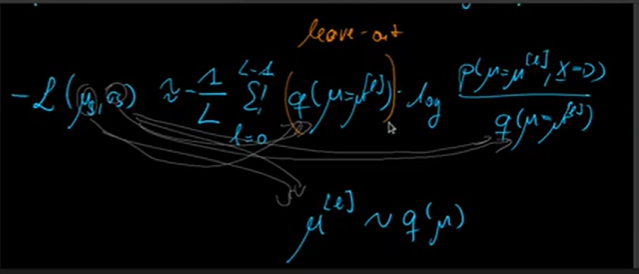

In [34]:
n_samples = 5
with tf.GradientTape() as g:
    samples = model_surrogate_posterior.sample(n_samples)
    neg_elbo = - tf.reduce_mean(model_joint_logprob(samples) - model_surrogate_posterior.log_prob(samples))  # log täljare - log nämnare

In [35]:
neg_elbo

<tf.Tensor: shape=(), dtype=float32, numpy=1561.5793>

In [36]:
g.gradient(neg_elbo, model_surrogate_posterior.trainable_variables)

(<tf.Tensor: shape=(), dtype=float32, numpy=-377.90005>,
 <tf.Tensor: shape=(), dtype=float32, numpy=59.173973>)

In [37]:
lr = 0.1
num_steps = 1000
sample_size = 100
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_joint_logprob,
    surrogate_posterior=model_surrogate_posterior,
    optimizer=tf.optimizers.Adam(lr),
    num_steps=num_steps,
    sample_size=sample_size)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([1614.1874, 1544.0953, 1504.5519, 1483.0312, 1473.4847, 1458.9009,
       1458.8594, 1461.5151, 1466.5212, 1469.8157, 1475.3644, 1470.1355,
       1466.1094, 1462.7446, 1456.0966, 1450.8846, 1446.9313, 1444.2072,
       1444.1821, 1445.0413, 1447.7864, 1446.3947, 1448.6868, 1448.4272,
       1448.961 , 1446.723 , 1445.5514, 1445.731 , 1443.7184, 1443.2695,
       1442.521 , 1442.7253, 1442.8428, 1442.9613, 1443.9386, 1444.2612,
       1444.1006, 1443.9452, 1443.3934, 1443.2021, 1442.6609, 1442.5425,
       1442.3796, 1442.5336, 1442.4224, 1442.593 , 1442.6204, 1442.4681,
       1442.7488, 1442.3668, 1442.5172, 1442.4569, 1442.2772, 1442.2644,
       1442.2579, 1442.3253, 1442.2773, 1442.3176, 1442.355 , 1442.3241,
       1442.2334, 1442.3328, 1442.2869, 1442.3152, 1442.3163, 1442.2595,
       1442.2043, 1442.24  , 1442.36  , 1442.269 , 1442.274 , 1442.3384,
       1442.2384, 1442.1978, 1442.2188, 1442.2373, 1442.2303, 1442.188 ,
  

Text(0.5, 1.0, 'model_surrogate_posterior post training')

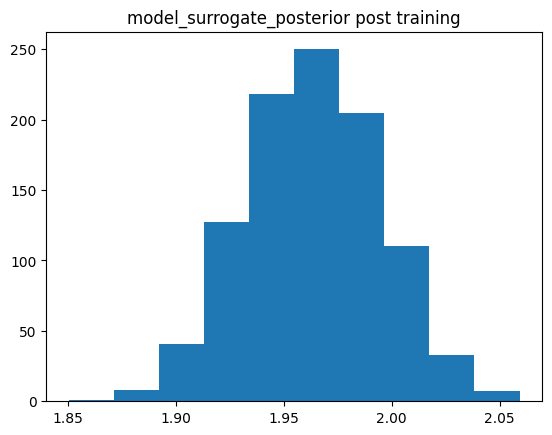

In [45]:
plt.hist(model_surrogate_posterior.sample(1000))

plt.title('model_surrogate_posterior post training')

In [39]:
mu_S

<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=1.9629344>

In [40]:
sigma_S

<TransformedVariable: dtype=float32, shape=[], fn="softplus", numpy=0.031857736>

In [41]:
sigma_N

<tf.Tensor: shape=(), dtype=float32, numpy=0.031448543>

In [42]:
mu_N

<tf.Tensor: shape=(), dtype=float32, numpy=1.963119>

In [43]:
mu_true

2

In [44]:
sigma_true

1